# Analysis with Random Forest class 1st shot
### Thorowing in all potentials imports - including the kitchen sink (needs clean up)

In [1]:
# %matplotlib inline
import os
import time
import pdb
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
from sklearn.metrics import (classification_report,
                             roc_auc_score, roc_curve)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from xgboost import (XGBClassifier, plot_tree)

from tqdm import tqdm
from load_data import load_parse_save
from hlp_analysis import (xstat, resample_split_data,
                          print_prediction_results,
                          pca_2d_imbal, pca2d_graph_imbal)

from warnings import filterwarnings
import missingno as msno

filterwarnings('ignore')

# Load data, group, & summarized from pickle file (if not then process entire) 

In [2]:
# Load Data from csv file & process via load_parse_save
pkl_file = './parsed_dataframe.pkl'
if os.path.isfile(pkl_file):
  # Alternative is Load from Pickled set: Saves Time
  with open(pkl_file, 'rb') as fp:
    ret_dict = pickle.load(fp)
else:
  # if not available, then process the entire from start
  tqdm.pandas(desc='load & parse csv')
  ret_dict = load_parse_save(save_file='./parsed_dataframe.pkl', debug=True)

prev_df = ret_dict['csv_df']      #: csv parse & load
grp = ret_dict['grp_dev_fail']    #: grouped by device & [Failed or Normal set]
g_stat_df = ret_dict['g_stat_df'] #: processing based on the grp above -> max, min, mean & # days prior to max & min

In [3]:
print("Group was created with following columns {}".format(grp.keys))

Group was created with following columns ['device', 'Fail_set']


### Add column Fail_set & mark it
Ideally, we would cut off data at least 1 days prior to Failure if possible,
as one does NOT want to wait until last min.
### = For some reason cutting off Fail Date did NOT make a huge difference so just keeping it

Only the data prev to fail is one group & other group is no Failure + post Failure
#### N.B.: This only works because there is only ONE failure for each device.
Must deal with multiple Fails on a device with a bit more sophistication, which is NOT needed here

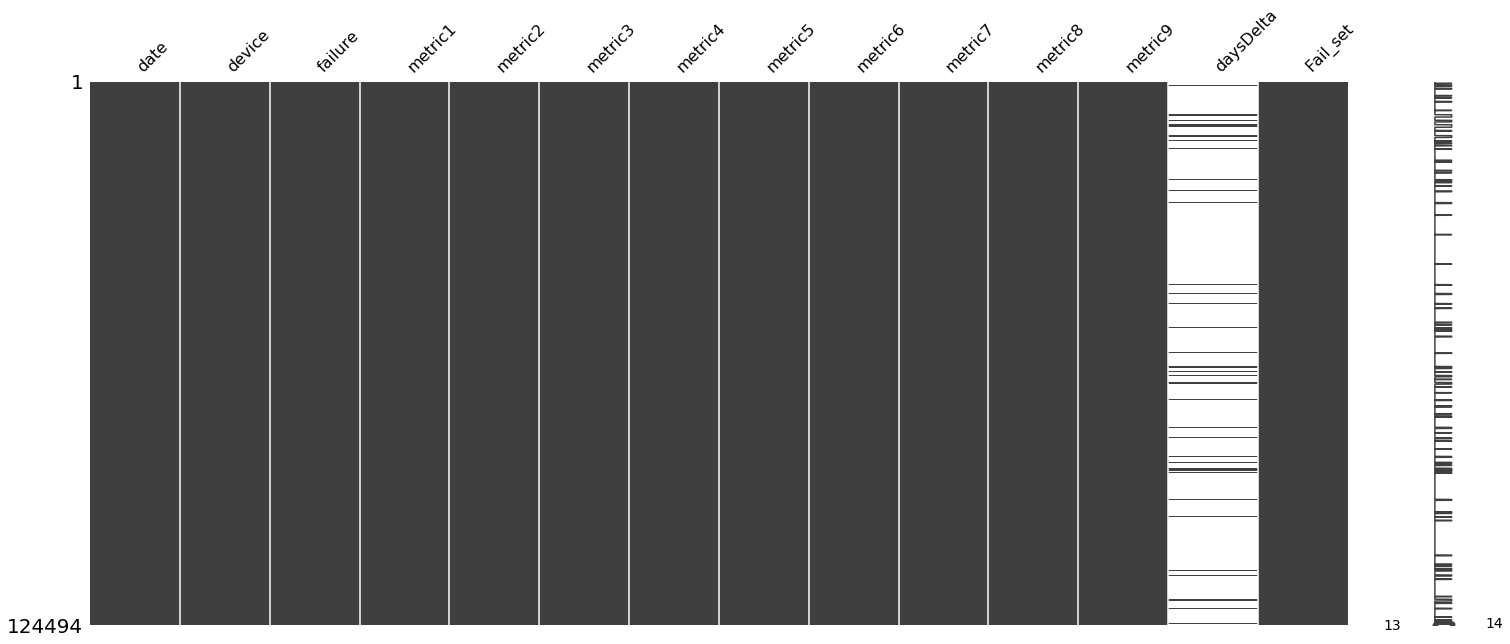

In [4]:
msno.matrix(prev_df)

### no Missing value to be filled or removed: daysDelta is not original series but inserted by me

In [5]:
print("All {:,}:  False={:,}, True={:,},  ratio={:,.1f}".format(prev_df.shape[0],
                                                prev_df[~prev_df.Fail_set].shape[0],
                                                prev_df[prev_df.Fail_set].shape[0],
                                                prev_df[~prev_df.Fail_set].shape[0] / prev_df[prev_df.Fail_set].shape[0]))

All 124,494:  False=113,828, True=10,666,  ratio=10.7


### It's apparent that Imbalanced Classification Problem exist in 10:1 ratio

In [6]:
mean = prev_df[~prev_df.Fail_set].mean()
std = prev_df[~prev_df.Fail_set].std()

### Look at 2 times the normal(unfailed) std from mean frequency via variable multiple_std=?
### Looking to narrow down the features

In [7]:
multiple_std = 2
drop_col = ['failure', 'Fail_set', 'daysDelta']
upper_bound = mean.drop(drop_col) + (std.drop(drop_col) * multiple_std)
uBound_df = pd.DataFrame.from_dict({col: prev_df[col] >= upper_bound[col]
                                    for col in prev_df.columns if col[:-1] == 'metric'})

uBound_df[['device', 'Fail_set']] = prev_df[['device', 'Fail_set']]
uBound_df = uBound_df.set_index(['device', 'Fail_set'])
grp_u = uBound_df.groupby(['Fail_set'])

print("Value 'ABOVE' {} standardeviation from the mean".format(multiple_std))
print(grp_u.sum().to_string())
print("metric 4, 7, 8, 9 looks promising")

Value 'ABOVE' 2 standardeviation from the mean
          metric1  metric2  metric3  metric4  metric5  metric6  metric7  metric8  metric9
Fail_set                                                                                 
False         0.0    872.0    519.0    557.0   6720.0   5489.0    230.0    230.0    383.0
True          0.0    121.0      0.0    478.0    592.0    153.0    422.0    422.0    132.0
metric 4, 7, 8, 9 looks promising


In [8]:
lower_bound = mean.drop(drop_col) - (std.drop(drop_col) * multiple_std)
lBound_df = pd.DataFrame.from_dict({col: prev_df[col] <= upper_bound[col]
                                    for col in prev_df.columns if col[:-1] == 'metric'})

lBound_df[['device', 'Fail_set']] = prev_df[['device', 'Fail_set']]
lBound_df = lBound_df.set_index(['device', 'Fail_set'])
grp_l = lBound_df.groupby(['Fail_set'])

# Lower bound seems to be about 10% -> not really doing much
print("Value 'BELOW' {} standardeviation from the mean".format(multiple_std))
print(grp_l.sum().to_string())
print("All metrics True are just about 10% of Fail_set = No meaning")

Value 'BELOW' 2 standardeviation from the mean
           metric1   metric2   metric3   metric4   metric5   metric6   metric7   metric8   metric9
Fail_set                                                                                          
False     113828.0  112956.0  113309.0  113271.0  107108.0  108339.0  113598.0  113598.0  113445.0
True       10666.0   10545.0   10666.0   10188.0   10074.0   10513.0   10244.0   10244.0   10534.0
All metrics True are just about 10% of Fail_set = No meaning


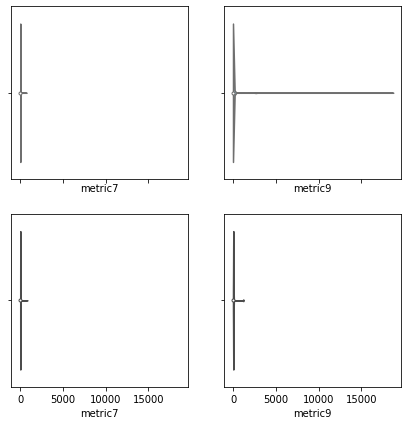

In [9]:
f, axes = plt.subplots(2,2, figsize=(7,7), sharex=True)
col_name = 'metric7'
sns.violinplot(prev_df[~prev_df.Fail_set][col_name], color='skyblue', label='Normal',  ax=axes[0, 0])
sns.violinplot(prev_df[prev_df.Fail_set][col_name], color='red', label='Failed',  ax=axes[1, 0])
col_name = 'metric9'
sns.violinplot(prev_df[~prev_df.Fail_set][col_name], color='skyblue', label='Normal',  ax=axes[0, 1])
sns.violinplot(prev_df[prev_df.Fail_set][col_name], color='red', label='Failed',  ax=axes[1, 1])

### This is a good place to look at variables via Dash by executing on a terminal:
```python metrics_comparison.py ``` 
#### _As matplotlib have an issue with multiple x/y axis-ranges_
Metric9 looks better than 7, but this is more of scale issue on x-axis

## Below is attempt to look at correlations of the variables for collinearity

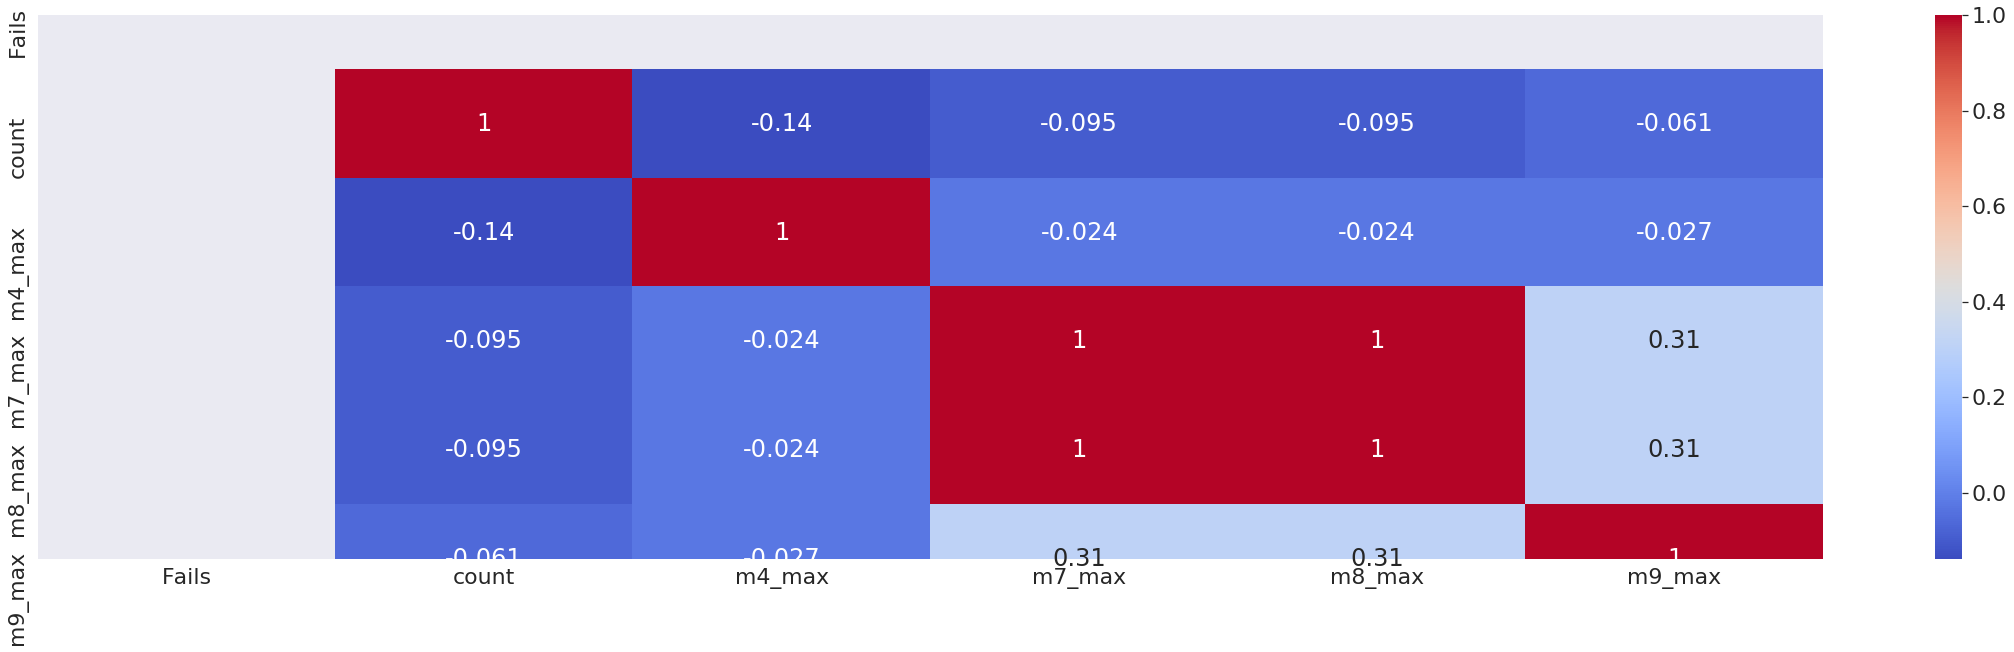

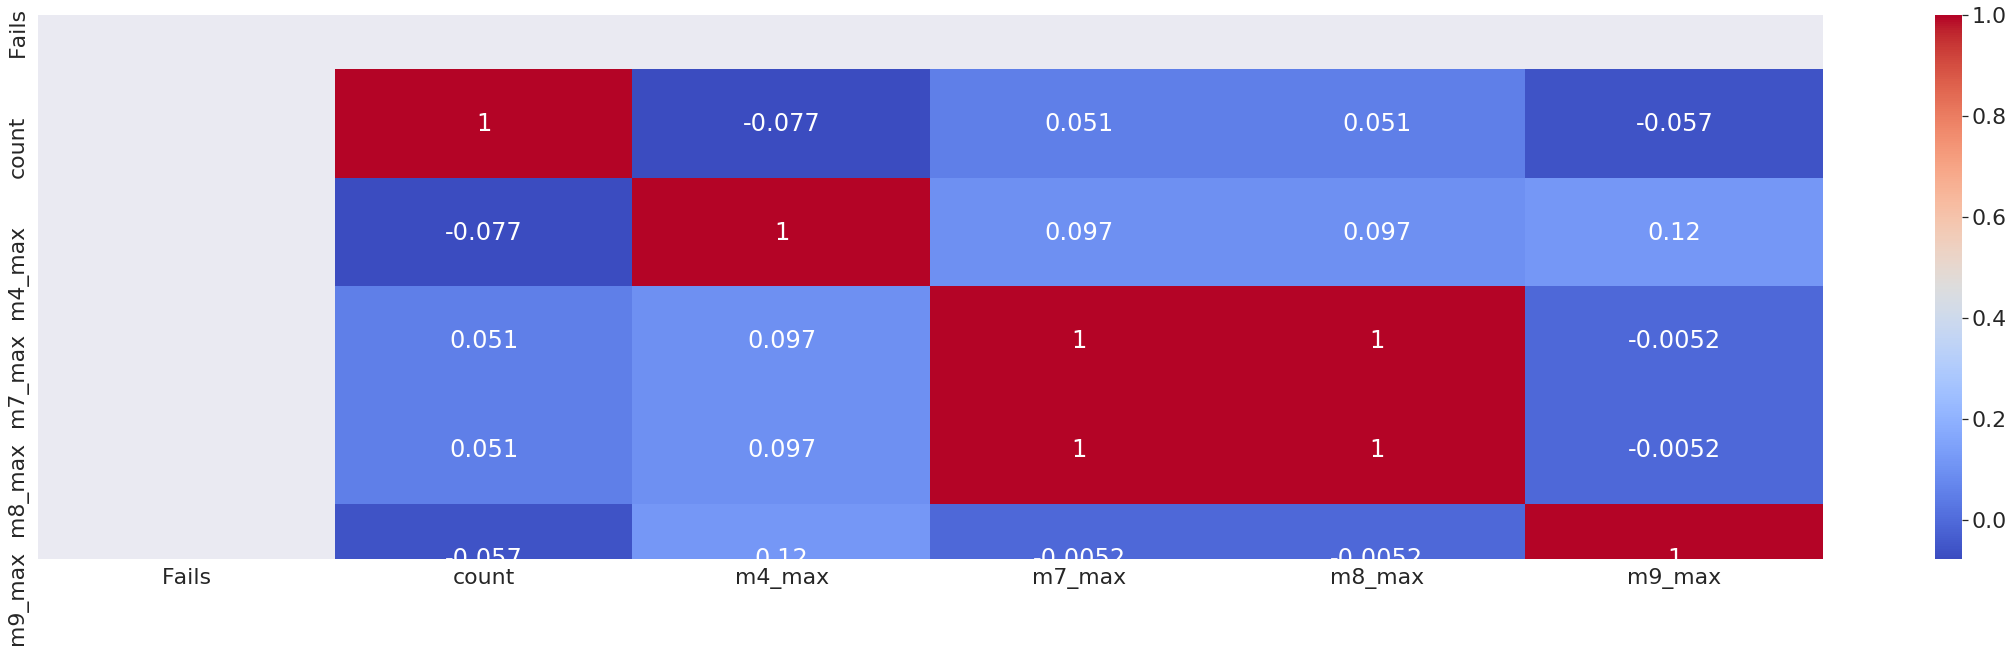

In [10]:
cols = ['Fails', 'count', 'm4_max', 'm7_max', 'm8_max', 'm9_max',]
fails_corr = g_stat_df[g_stat_df.Fails][cols].fillna(0).corr()
normal_corr = g_stat_df[~g_stat_df.Fails][cols].fillna(0).corr()

sns.set(font_scale=2)
plt.figure(figsize=(40, 10))
sns.heatmap(fails_corr, cmap='coolwarm', annot=True)
plt.show()

sns.set(font_scale=2)
plt.figure(figsize=(40, 10))
sns.heatmap(normal_corr, cmap='coolwarm', annot=True)
plt.show()

### Split the data into Train & Test, then use Random Forest to Predict
#### Models are quite volitle based on the columns chosen

In [11]:
#g_stat_df.xs(True, level='Fail_set').head()
x_model_cols = [col for col in g_stat_df.columns if col[-4:-2] == '_m' or col == 'count']
print(x_model_cols)

['count', 'm1_max', 'm1_min', 'm2_max', 'm2_min', 'm3_max', 'm3_min', 'm4_max', 'm4_min', 'm5_max', 'm5_min', 'm6_max', 'm6_min', 'm7_max', 'm7_min', 'm8_max', 'm8_min', 'm9_max', 'm9_min']


## Visualize using PCA one can see how sampling of imbalances effect the models
- The imbalance sampling appears to be great contributor to the model performance
- The performance fluctuates from high 70% to low 90% on accuracy & F1-score
- To increase F1 only 50% of dominant was used

Distribution before imbalancing: Counter({False: 1068, True: 106})
Distribution after  imbalancing: Counter({True: 106, False: 53})


No handles with labels found to put in legend.


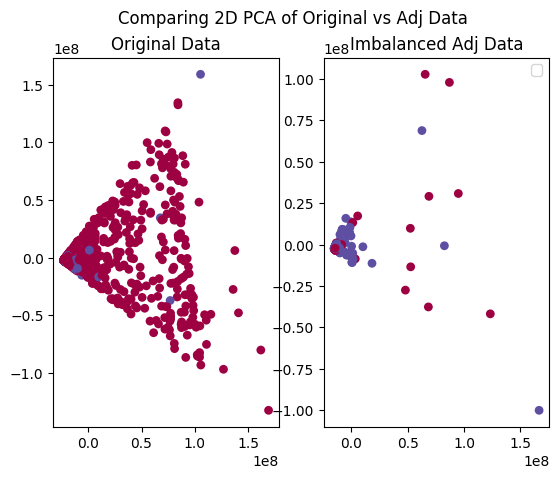

In [12]:
X_train, X_test, y_train, y_test = resample_split_data(g_stat_df, x_cols=x_model_cols, 
                                                       resample_ratio=.5, debug=True)

pca2d_graph_imbal(g_stat_df, x_model_cols, X_train, y_train)

In [13]:
RF_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
RF_clf.fit(X_train, y_train)

y_pred = RF_clf.predict(X_test)

In [14]:
print("Random Forrest Model")
print_prediction_results(y_train, y_test, y_pred)

Random Forrest Model
Result from confusion_matrix
[[13  4]
 [ 1 30]]

Training data had 111 data points & 75 fails
Testing  data had 48 data points & 31 fails
Out of 31 Fails, predicted 30 or 96.8% correctly
Accuracy: 89.583%
*F1_score = 92.3%


## Accuracy of the model
Confusion Matrix
![Confusion matrix](img/ConfusionMatrix.png)
#### N.B. General Accuracy is extremely misleading as imbalance class issue comes up
#### This is business decision as some business cannot tolerate any fails/downtime like electronic manufacturing.
In this case nearly or all potential fails must be investigated even if few dozen UnFails creep in for every REAL Failures.

# Boosted Models
For imbalanced data usual techniques are:
- Random over & under Resampling (Either can disregard useful data w/ undersample or overfit w/ oversample)
- Clustered over-sampling (outperfoms underampling & outperforms it, but often over fits)
- SMOT (Synthetic Minority Over-sampling Technique): Really difficult wiht hi-dim data
- Bagging: Only works if based classifiers distribution is not extreme
- Various Boosting (Ada, Gradient, & XG): Ada Sensitive, XG fast & less prone to issues

In [15]:
#boost_clf = AdaBoostClassifier( DecisionTreeClassifier(max_depth=1), n_estimators=200 )
boost_clf = XGBClassifier()

boost_clf.fit(X_train, y_train)
predictions = boost_clf.predict(X_test)

# *** Volatile F1 65-75% without imbalance adj BUT climbs to 80-90% w/ adj ***
- The results are better F1 score & hit ratio, but still very data random selection dependent.
- Likely results of using max/min from the metrics + needs better agg_metrics/factors
- The confusion matrix seems to indicate that model is still dominated by dominant classifier.
- Indicating that results may be better with Either sampling or SMOT 
- So, reduced resample ratio to 1/2 of the minor classification, which is a bit extreme
- Ada or XG boost do about 3+/-% difference on F1 score vs RF: Not quite helpful though
- Highest F1 was about 98%, which is unusual but given small data not unusual

In [16]:
print("XGBoost Model")
print_prediction_results(y_train, y_test, predictions)

XGBoost Model
Result from confusion_matrix
[[11  6]
 [ 1 30]]

Training data had 111 data points & 75 fails
Testing  data had 48 data points & 31 fails
Out of 31 Fails, predicted 30 or 96.8% correctly
Accuracy: 85.417%
*F1_score = 89.6%


## Visualizaiton plot of Single decision tree

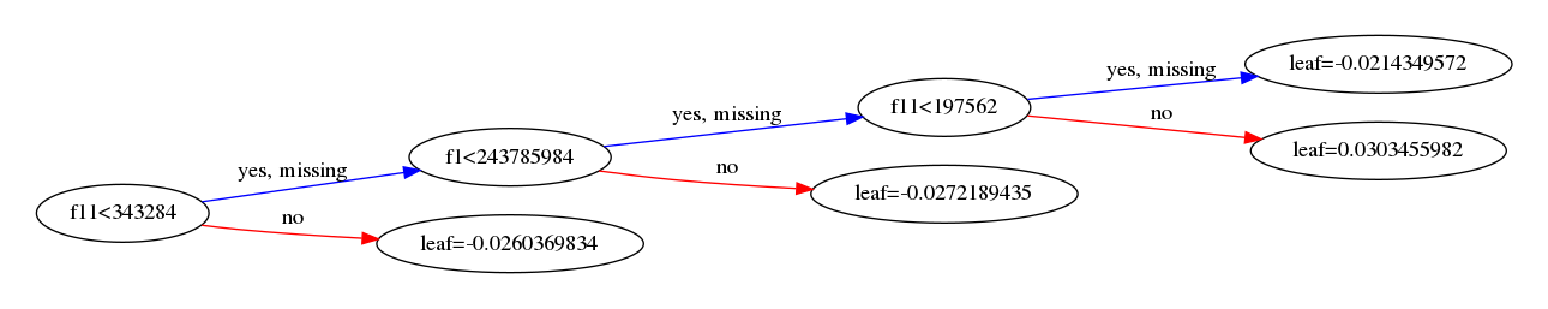

In [17]:
mpl.rcParams['figure.dpi'] = 300
#%config InlineBackend.figure_format = 'svg'

plot_tree(boost_clf, num_trees=99, rankdir='LR')
plt.show()

In [18]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE


X_train, X_test, y_train, y_test = resample_split_data(g_stat_df, x_cols=x_model_cols, resample_ratio=.5, debug=True)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('\nAccuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print_prediction_results(y_train, y_test, y_pred)
print(classification_report(y_test, y_pred))

Distribution before imbalancing: Counter({False: 1068, True: 106})
Distribution after  imbalancing: Counter({True: 106, False: 53})

Accuracy of logistic regression classifier on test set: 0.73
Result from confusion_matrix
[[ 5 10]
 [ 3 30]]

Training data had 111 data points & 73 fails
Testing  data had 48 data points & 33 fails
Out of 33 Fails, predicted 30 or 90.9% correctly
Accuracy: 72.917%
*F1_score = 82.2%
              precision    recall  f1-score   support

       False       0.62      0.33      0.43        15
        True       0.75      0.91      0.82        33

    accuracy                           0.73        48
   macro avg       0.69      0.62      0.63        48
weighted avg       0.71      0.73      0.70        48



### sm.Logit model sometimes do NOT work at the 1st try again if this happens, 
which may be due to reason stated below or just a bug?

In [20]:
x_model_cols = [col for col in g_stat_df.columns if col[-4:] == '_max' or col == 'count']
X_train, X_test, y_train, y_test = resample_split_data(g_stat_df, x_cols=x_model_cols, 
                                                       resample_ratio=.5, debug=True)
print('X shape {}'.format(X_train.shape))

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

#Logit, it is possible that there is complete separation, or quasi-complete separation. 
#In this case some parameters might go off to infinity and the optimization stops at 
#some convergence or stopping criterion. 
#Logit detect the simple case of full separation and raises an exception, 
#but there could be partial separation that is not detected. 
#With perfect separation you get perfect predictability for some or all cases, 
#which is useful for prediction but causes problems in estimating and identifying the parameters.

Distribution before imbalancing: Counter({False: 1068, True: 106})
Distribution after  imbalancing: Counter({True: 106, False: 53})
X shape (111, 10)
         Current function value: 0.352851
         Iterations: 35
                                   Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.464     
Dependent Variable:        y                      AIC:                    96.3328   
Date:                      2019-11-17 10:57       BIC:                    120.7186  
No. Observations:          111                    Log-Likelihood:         -39.166   
Df Model:                  8                      LL-Null:                -73.107   
Df Residuals:              102                    LLR p-value:            1.2967e-11
Converged:                 0.0000                 Scale:                  1.0000    
No. Iterations:            35.0000                                                  
------------------------------------------------------

## The p-values for most of the features are too high: probably able to get away with just using less, 
## but I get a singular matrix error so Keeping as is

In [21]:
# The columns below are result of RFE (Recursive Feature Elimination)
#x_model_cols = ['m9_max', 'm9_min', 'm5_min', 'm5_max', 'm7_min', 'm8_min', 'm3_min', 'm4_min', 'm1_max']

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print_prediction_results(y_train, y_test, y_pred)

Result from confusion_matrix
[[ 4  8]
 [ 4 32]]

Training data had 111 data points & 70 fails
Testing  data had 48 data points & 36 fails
Out of 36 Fails, predicted 32 or 88.9% correctly
Accuracy: 75.000%
*F1_score = 84.2%


## Visualizing ROC as a graph

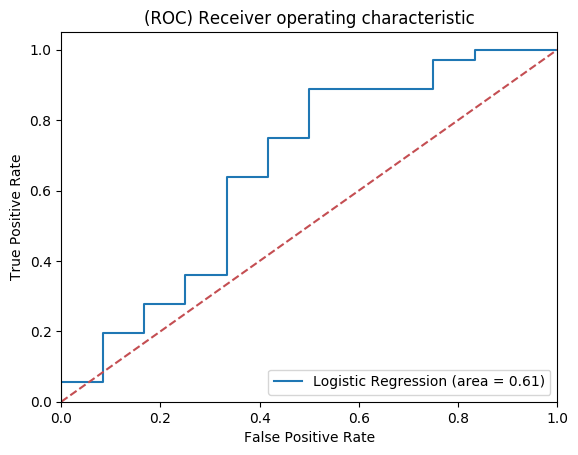

In [22]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

mpl.rcParams.update(mpl.rcParamsDefault)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Attempting Recursive Feature Elimination (RFE)

In [23]:
rfe = RFE(logreg, 7)
rfe = rfe.fit(X_train, y_train)
col_rfe = pd.DataFrame(zip(x_model_cols, rfe.support_, rfe.ranking_), columns=['col', 'support', 'ranking']).sort_values('ranking', ascending=False)
col_rfe[~col_rfe.support].col.tolist()

['m3_max', 'm5_max', 'm9_max']

In [24]:
# from sklearn.utils import check_random_state

x_model_cols = [col for col in g_stat_df.columns if col[-4:-2] == '_m' or col == 'count']
x_model_cols = ['m7_min', 'm8_min', 'm3_min', 'm3_max', 'm9_min', 'm2_min', 'm9_max', 
                'm4_min', 'm5_max', 'm5_min', ]

X_train, X_test, y_train, y_test = resample_split_data(g_stat_df, x_cols=x_model_cols, 
                                                       resample_ratio=.5, debug=True)
generator = check_random_state(0)

RF_clf = RandomForestClassifier(n_estimators=100) #, random_state=generator, max_depth=3)

#Train the model using the training sets y_pred=clf.predict(X_test)
RF_clf.fit(X_train, y_train)

y_pred = RF_clf.predict(X_test)
clf = RandomForestClassifier(n_estimators=20,
                               random_state=generator, max_depth=2)
rfe = RFE(estimator=RF_clf, n_features_to_select=4, step=0.1)
rfe.fit(X_train, y_train)

print_prediction_results(y_train, y_test, y_pred)
print(classification_report(y_test, y_pred))

col_rfe = pd.DataFrame( zip(x_model_cols, rfe.support_, rfe.ranking_), columns=['col', 'support', 'ranking']).sort_values('ranking', ascending=False)
print(col_rfe[~col_rfe.support].col.tolist())
col_rfe


Distribution before imbalancing: Counter({False: 1068, True: 106})
Distribution after  imbalancing: Counter({True: 106, False: 53})
Result from confusion_matrix
[[ 7  6]
 [ 5 30]]

Training data had 111 data points & 71 fails
Testing  data had 48 data points & 35 fails
Out of 35 Fails, predicted 30 or 85.7% correctly
Accuracy: 77.083%
*F1_score = 84.5%
              precision    recall  f1-score   support

       False       0.58      0.54      0.56        13
        True       0.83      0.86      0.85        35

    accuracy                           0.77        48
   macro avg       0.71      0.70      0.70        48
weighted avg       0.77      0.77      0.77        48

['m8_min', 'm7_min', 'm3_min', 'm3_max', 'm4_min', 'm9_max']


,col,support,ranking
1,m8_min,False,7
0,m7_min,False,6
2,m3_min,False,5
3,m3_max,False,4
7,m4_min,False,3
6,m9_max,False,2
4,m9_min,True,1
5,m2_min,True,1
8,m5_max,True,1
9,m5_min,True,1


### Trying one more model PCA w/ logistic pipeline
- Remakably only 1 component feature from PCA did well, when compared to using more PCA feature components 
- Pretty descent model but accuracy or F1-score is well below other models
- Wonder if we can get away with just using SVM

In [25]:
pca = PCA(n_components=1)
clf = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', clf)])
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

print_prediction_results(y_train, y_test, y_pred)
print(classification_report(y_test, y_pred))

### Wonder if NN does any better

Result from confusion_matrix
[[ 7  6]
 [ 5 30]]

Training data had 111 data points & 71 fails
Testing  data had 48 data points & 35 fails
Out of 35 Fails, predicted 30 or 85.7% correctly
Accuracy: 77.083%
*F1_score = 84.5%
              precision    recall  f1-score   support

       False       0.58      0.54      0.56        13
        True       0.83      0.86      0.85        35

    accuracy                           0.77        48
   macro avg       0.71      0.70      0.70        48
weighted avg       0.77      0.77      0.77        48

